In [82]:
import torch
from torch import nn

from uqvae.models.base import Encoder, Decoder
from uqvae.dataset import load
from uqvae import utils
from uqvae.metrics import mutual_information

import os
import yaml

from types import SimpleNamespace

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams["text.usetex"] = True

In [83]:
vnum = 12
f = os.path.normpath(f"../lightning_logs/version_{vnum}")
with open(os.path.join(f, "hparams.yaml")) as stream:
    hparams = SimpleNamespace(**yaml.safe_load(stream))

device = torch.device("cuda" if hparams.cuda else "cpu")
best_state_dict = torch.load(
    os.path.join(f, "checkpoints/best.ckpt"), map_location=device
)
data_transformer = torch.load(os.path.join(f, "checkpoints/data_transformer.ckpt"))

In [84]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x).rsample()
        pxz = self.decoder(z)
        return pxz.loc(), pxz.scale()


with utils.reproduce(seed=42):
    encoder = Encoder(hparams.data_dim, hparams.compress_dims, hparams.embedding_dim)
    decoder = Decoder(hparams.embedding_dim, hparams.decompress_dims, hparams.data_dim)
    vae = VAE(encoder, decoder).to(device)
    vae.load_state_dict(best_state_dict["state_dict"])

In [4]:
data, _, _, _ = load("../data/fulldataset.csv")
tdata = data_transformer.transform(data.astype("float32"))

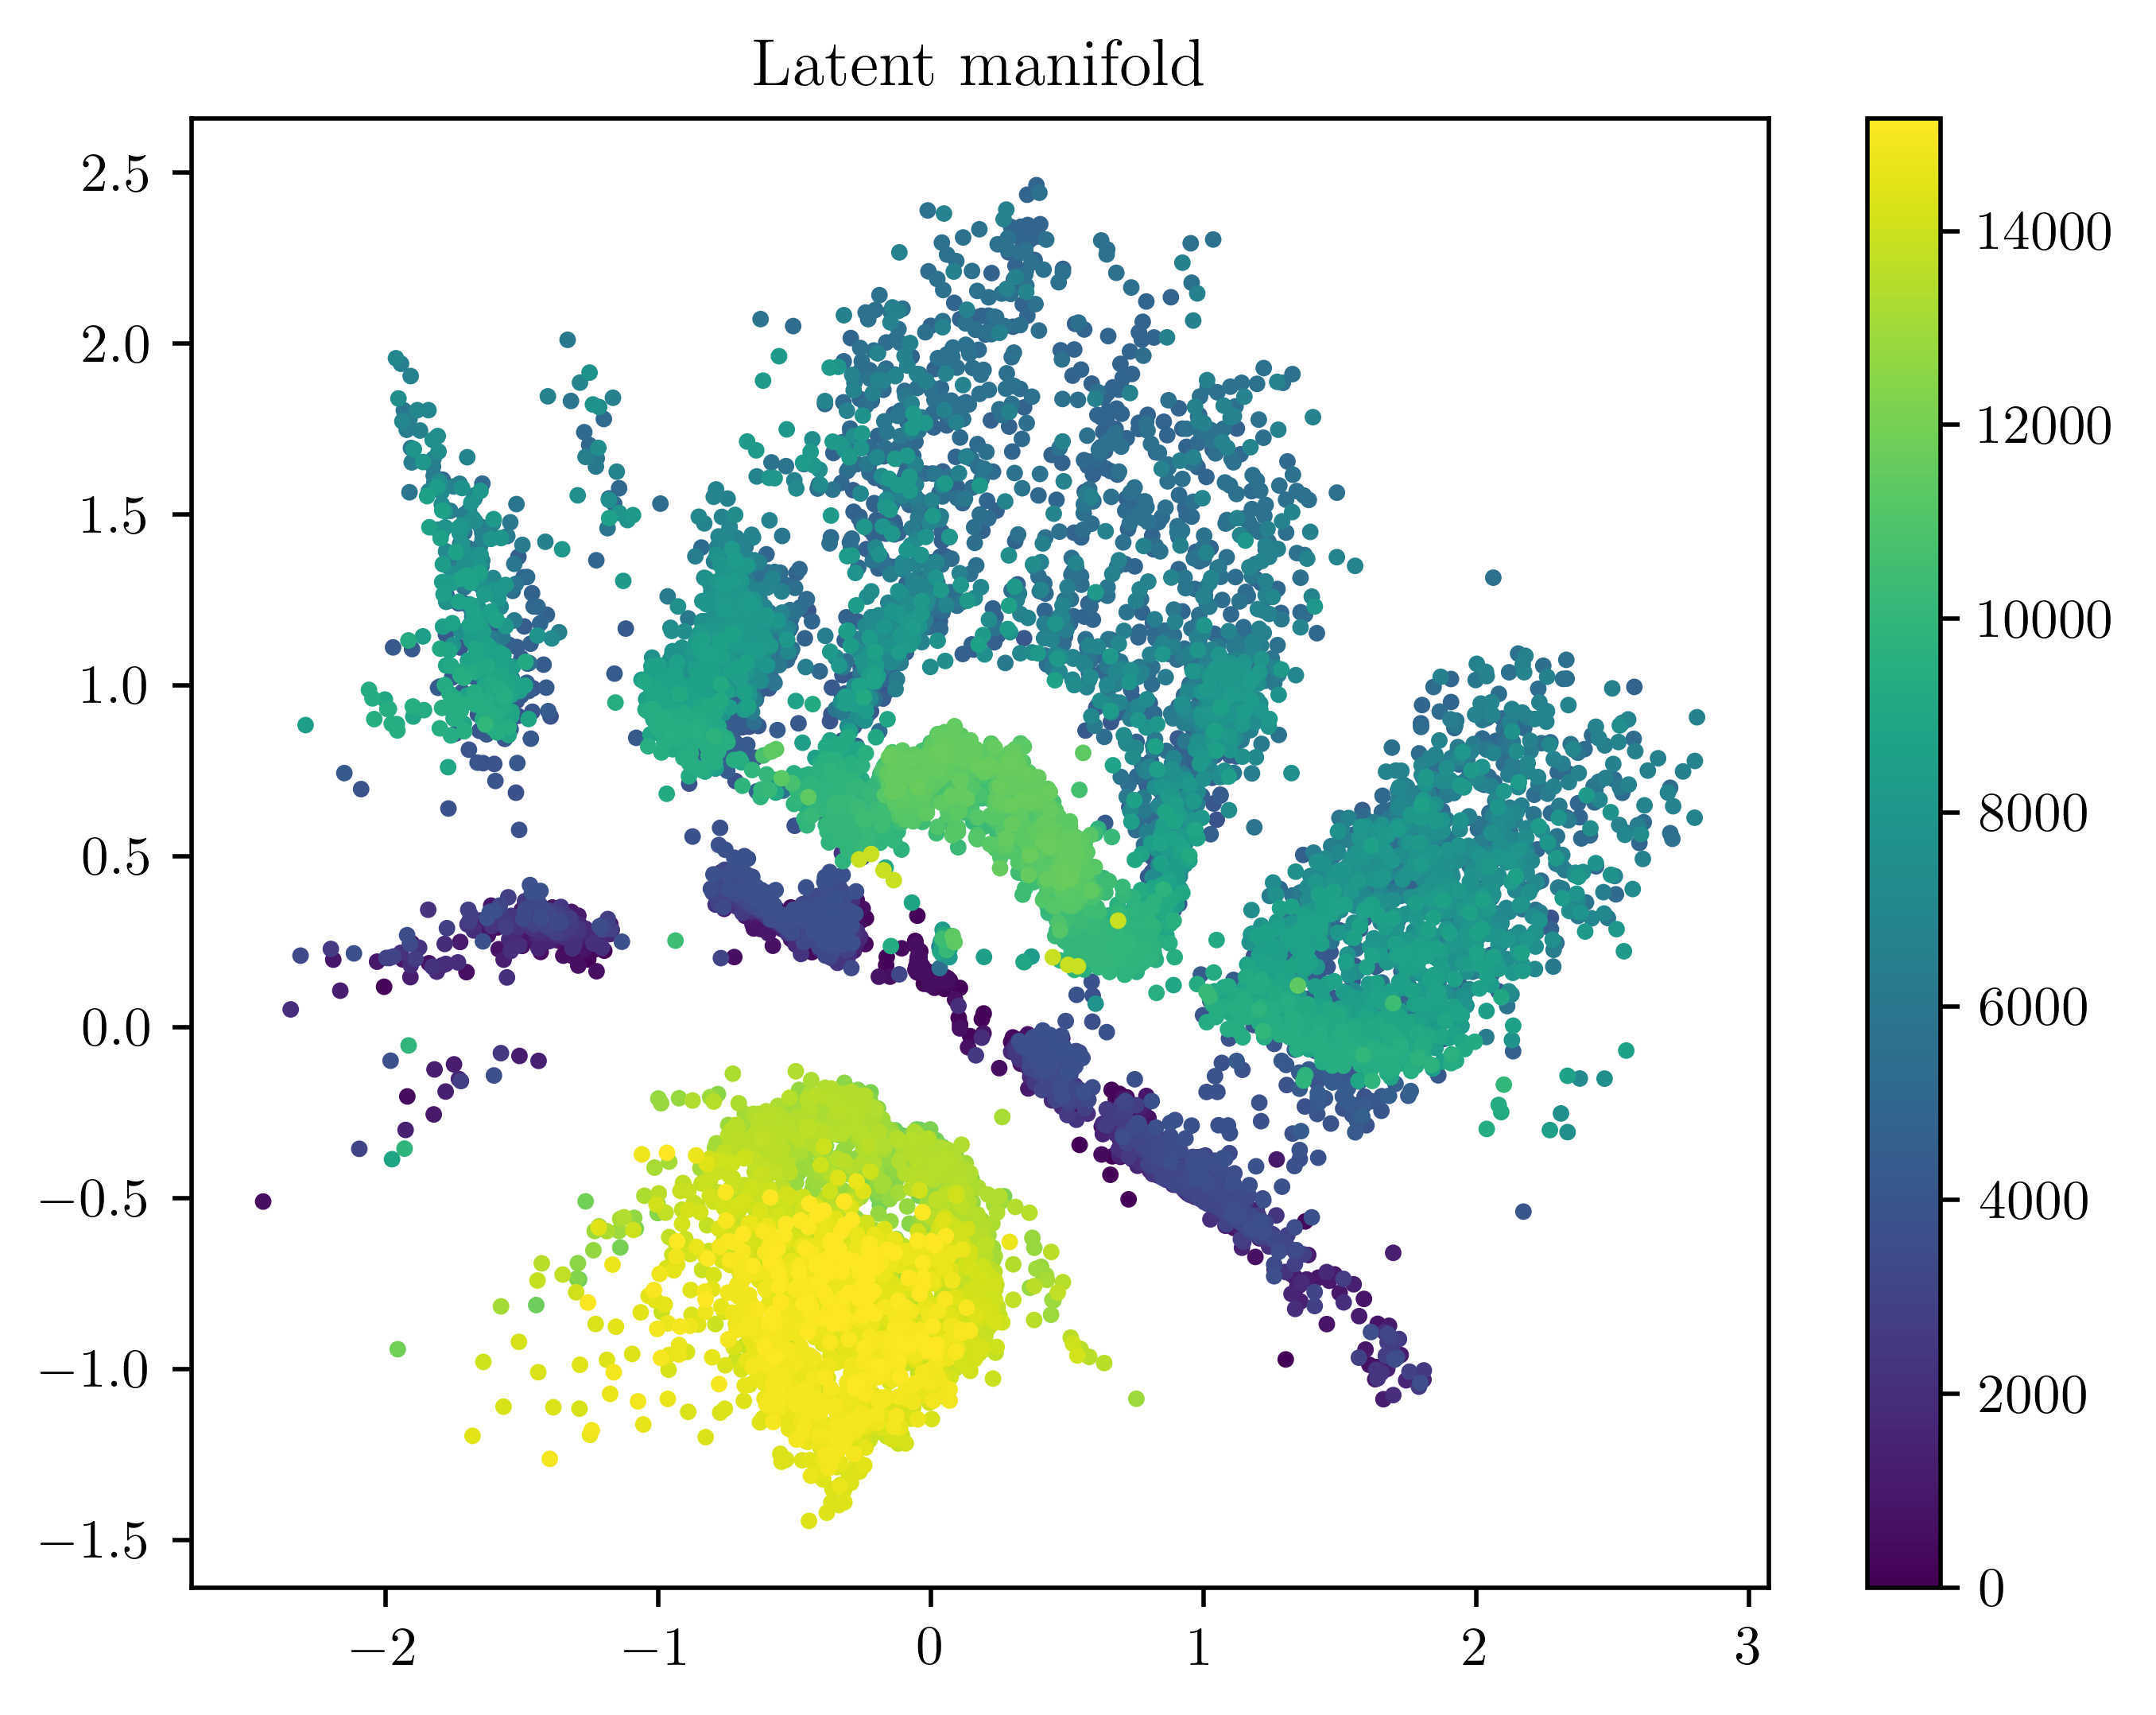

In [85]:
with torch.no_grad():
    x = torch.as_tensor(tdata, device=device, dtype=torch.float32)
    z = vae.encoder(x).rsample().cpu()

plt.figure(dpi=500)
plt.title("Latent manifold")
plt.scatter(
    *np.split(z, 2, 1),
    c=data.index.tolist(),
    vmin=min(data.index.tolist()),
    vmax=max(data.index.tolist()),
    s=4,
)
plt.colorbar()

In [45]:
x = torch.linspace(-20.0, 20.0, 200)
y = torch.linspace(-20.0, 20.0, 200)
x, y = torch.meshgrid(x, y, indexing="xy")
ZZ = torch.vstack((x.flatten(), y.flatten())).t()
f_vals = (
    mutual_information(
        vae.decoder,
        ZZ.to(device),
        n_simulations=100,
        n_sampled_outcomes=10,
    )
    .detach()
    .cpu()
)

mutual_information: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


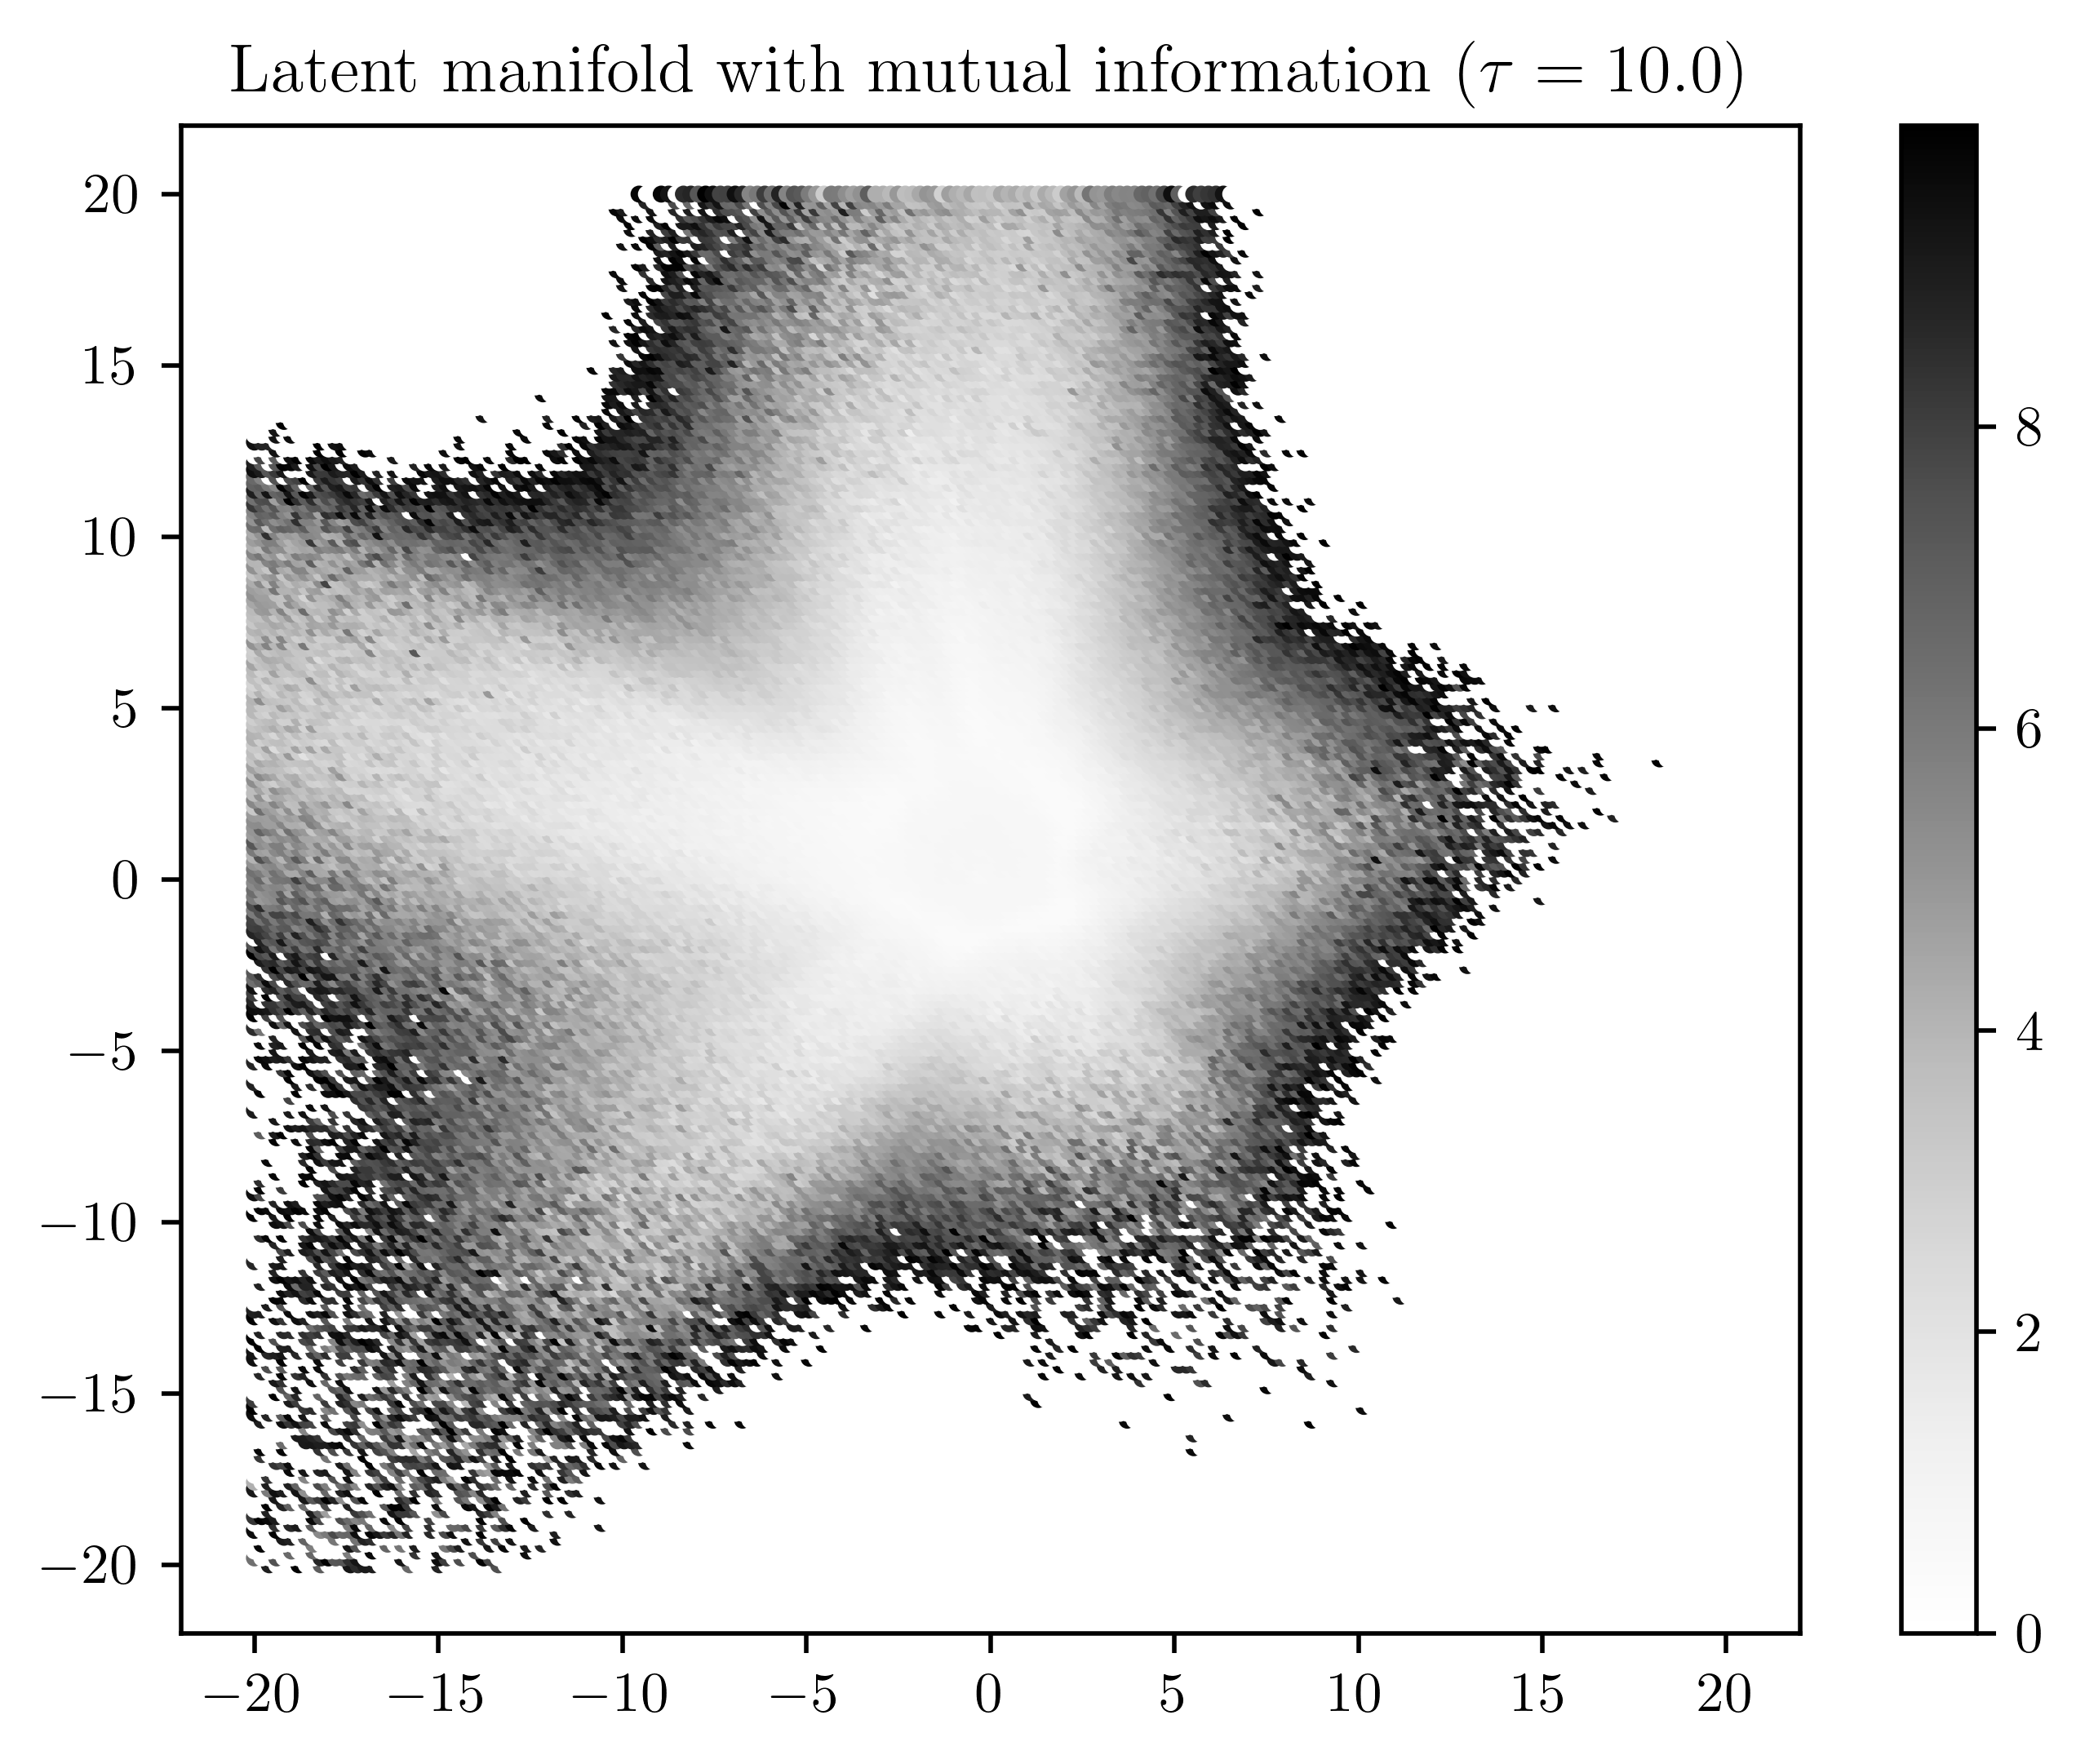

In [57]:
mask = torch.where(f_vals > 10.0, 0.0, f_vals)

plt.figure(dpi=500)
plt.title(r"Latent manifold with mutual information ($\displaystyle\tau=10.0$)")
plt.scatter(
    *np.split(ZZ, 2, 1),
    c=mask,
    vmin=min(mask),
    vmax=max(mask),
    s=4,
    cmap=plt.get_cmap("Greys")
)
plt.colorbar()

In [72]:
data, _, _, targets = load("../data/fulldataset.csv")
mask = np.where(targets.notna().all(1))[0]

x = data.iloc[mask,:]
y = targets.iloc[mask,0]

In [74]:
class DataWeighter:
    def __init__(self, hparams):
        if hparams.weight_type in ["uniform"]:
            self.weighting_function = DataWeighter.uniform_weights
        else:
            raise NotImplementedError
        
        self.weight_quantile = hparams.weight_quantile
        self.weight_type = hparams.weight_type

    @staticmethod
    def normalize_weights(weights: np.array):
        return weights / np.mean(weights)

    @staticmethod
    def uniform_weights(properties: np.array):
        return np.ones_like(properties)
    

def set_weights(data, properties):
    weights = DataWeighter.uniform_weights(properties.values.astype("float32"))
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),
        replacement=True,
    )
    print(weights)
    
set_weights(x, y)

[1. 1. 1. ... 1. 1. 1.]


In [94]:
train_dataset = torch.utils.data.TensorDataset(torch.randn(10, 4))
ss_train_dataset = torch.utils.data.TensorDataset(torch.randn(2, 4), torch.randn(2, 1))


In [95]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset, ss_train_dataset))

In [97]:
for batch in loader:
    batch1, batch2 = batch
    x, = batch1
    xx, yy = batch2
    print(x.size())
    print(xx.size())
    print(yy.size())
    break

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 1])
